# **Import needed modules**

In [6]:
import os
import pandas as pd
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
import timm

import warnings
warnings.filterwarnings("ignore")
set_seed(42)

print('모듈이 로드되었습니다.')

모듈이 로드되었습니다.


# **Data Preprocessing**

#### **Read data and store it in dataframe**

In [3]:
# Generate data paths with labels
data_dir = 'dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
df

,filepaths,labels
0,dataset/lightning/2100.jpg,lightning
1,dataset/lightning/2114.jpg,lightning
2,dataset/lightning/2128.jpg,lightning
3,dataset/lightning/1838.jpg,lightning
4,dataset/lightning/1964.jpg,lightning
...,...,...
6857,dataset/snow/1438.jpg,snow
6858,dataset/snow/1362.jpg,snow
6859,dataset/snow/1404.jpg,snow
6860,dataset/snow/1410.jpg,snow


In [5]:
dls = ImageDataLoaders.from_df(df,
                                fn_col=0, # filepaths
                                label_col=1, # labels
                                valid_pct=0.2,
                                folder='', 
                                item_tfms=Resize(224))

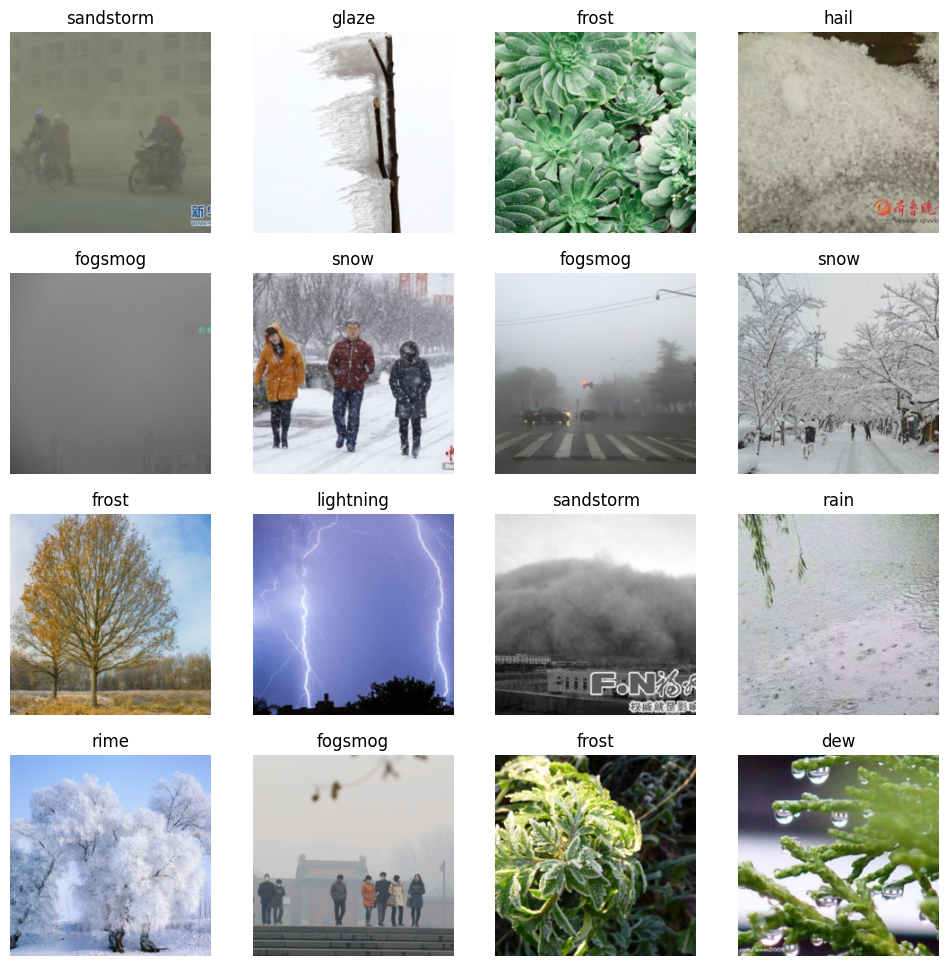

In [6]:
dls.show_batch(max_n=16)

# **Model Structure**

In [8]:
learn = vision_learner(dls, 'efficientnet_b3', metrics=[accuracy, error_rate], path='.').to_fp16()
learn.summary()

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

KeyboardInterrupt: 

## **Training**

In [41]:
learn.fit_one_cycle(20)

NameError: name 'learn' is not defined

In [42]:
learn.show_results()

NameError: name 'learn' is not defined

In [43]:
# Save the model
learn.save("models")

NameError: name 'learn' is not defined

In [44]:
# Build a Classification Interpretation object from our learn model
# it can show us where the model made the worse predictions:
interp = ClassificationInterpretation.from_learner(learn)

NameError: name 'learn' is not defined

In [45]:
# Plot the top ‘n’ classes where the classifier has least precision.
interp.plot_top_losses(12, figsize=(15,15))

NameError: name 'interp' is not defined

In [46]:
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

NameError: name 'interp' is not defined

In [47]:
#To view the list of classes most misclassified as a list
interp.most_confused(min_val=2) #We are ignoring single image misclassification

#Sorted descending list of largest non-diagonal entries of confusion matrix, 
#presented as actual, predicted, number of occurrences.

NameError: name 'interp' is not defined

ModuleNotFoundError: No module named 'models.common'

In [37]:


# TTS 엔진 초기화
engine = pyttsx3.init()

# 경고 메시지를 음성으로 출력하는 함수
def speak_warning(message):
    engine.say(message)
    engine.runAndWait()

# 날씨 예측 모델 로드
learn = vision_learner(dls, 'efficientnet_b3', metrics=[accuracy, error_rate], path='.').to_fp16()
learn.load("models")  # 저장된 모델 불러오기

# 포트홀 감지 YOLOv5 모델 로드
weights = "/Users/yeonjae-jeong/Documents/PotholeDetector/yolov5/runs/train/pothole_yolov5s_results/weights/best.pt"
device = select_device("")
yolo_model = DetectMultiBackend(weights, device=device)
yolo_stride = yolo_model.stride
imgsz = [640, 640]  # YOLOv5 입력 이미지 크기

# MiDaS 모델 로드 (깊이 예측)
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(midas_device).eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform

# 프레임에서 날씨를 예측하는 함수
def predict_weather_from_frame(frame):
    img = PILImage.create(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = img.resize((224, 224))
    pred, _, probs = learn.predict(img)
    return pred, probs.max().item()

# 위험한 날씨인지 판단하는 함수
def is_dangerous_weather(pred):
    dangerous_conditions = ['sandstorm', 'rain', 'glaze', 'rime', 'snow']  # 위험한 날씨 목록
    return pred in dangerous_conditions

# 포트홀 탐지 및 깊이 맵 추출 함수
def detect_potholes_and_depth(frame):
    # MiDaS 깊이 예측
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_batch = midas_transforms(img_rgb).to(midas_device)
    with torch.no_grad():
        prediction = midas(input_batch)
        depth_map = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=frame.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze().cpu().numpy()

    # YOLOv5 포트홀 감지
    img_tensor = torch.from_numpy(frame).to(device).float()
    img_tensor /= 255.0  # [0, 1]로 정규화
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)  # 모델 입력 형식에 맞게 조정
    pred = yolo_model(img_tensor)
    pred = non_max_suppression(pred)

    # 감지 결과 표시
    for det in pred:
        if len(det):
            det[:, :4] = scale_boxes(img_tensor.shape[2:], det[:, :4], frame.shape).round()
            for *xyxy, conf, cls in det:
                depth_value = depth_map[int((xyxy[1] + xyxy[3]) // 2), int((xyxy[0] + xyxy[2]) // 2)]
                label = f"Pothole Detected, Depth: {depth_value:.2f}"
                cv2.rectangle(frame, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
                cv2.putText(frame, label, (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                speak_warning(f"Pothole detected with depth {depth_value:.2f} meters.")
    return frame

# 웹캠 초기화
cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # 현재 프레임에서 날씨 예측
    pred, prob = predict_weather_from_frame(frame)
    
    # 프레임에 예측 결과 표시
    weather_label = f'Prediction: {pred}, Confidence: {prob:.2f}'
    cv2.putText(frame, weather_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # 위험한 날씨 감지 및 경고
    if is_dangerous_weather(pred) and prob >= 0.95:
        speak_warning(f"Dangerous weather detected: {pred}.")
    
    # 포트홀 탐지 및 경고
    frame = detect_potholes_and_depth(frame)

    # 프레임 출력
    cv2.imshow('Weather and Pothole Detection', frame)
    
    # 'q'를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 리소스 해제
cap.release()
cv2.destroyAllWindows()

Using cache found in /Users/yeonjae-jeong/.cache/torch/hub/ultralytics_yolov5_master


ModuleNotFoundError: No module named 'models.common'

In [40]:
import sys
import os

# yolov5 경로 재설정
yolov5_path = '/Users/yeonjae-jeong/Documents/PotholeDetector/yolov5'
if yolov5_path in sys.path:
    sys.path.remove(yolov5_path)

models_path = os.path.join(yolov5_path, 'models')
if models_path in sys.path:
    sys.path.remove(models_path)

# 경로 추가
sys.path.insert(0, yolov5_path)
sys.path.insert(0, models_path)

# 중복 경로 제거
sys.path = list(dict.fromkeys(sys.path))

# 경로 출력
print(sys.path)

# 모델 로드 시도
try:
    from models.common import DetectMultiBackend
    print("Module imported successfully!")
except ModuleNotFoundError as e:
    print(f"Error: {e}")

['/Users/yeonjae-jeong/Documents/PotholeDetector/yolov5/models', '/Users/yeonjae-jeong/Documents/PotholeDetector/yolov5', '/opt/anaconda3/envs/myenv/lib/python312.zip', '/opt/anaconda3/envs/myenv/lib/python3.12', '/opt/anaconda3/envs/myenv/lib/python3.12/lib-dynload', '', '/opt/anaconda3/envs/myenv/lib/python3.12/site-packages', '/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/setuptools/_vendor', '/yolov5']
Error: No module named 'models.common'


## **Thank You..**
If you find this notebook is good enough, please upvote it..

In [41]:
from models.common import DetectMultiBackend
import torch

# YOLOv5 모델 로드
weights = '/Users/yeonjae-jeong/Documents/PotholeDetector/yolov5/runs/train/pothole_yolov5s_results/weights/best.pt'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model = DetectMultiBackend(weights, device=device)

ModuleNotFoundError: No module named 'models.common'